In [1]:
import spatialdata
import spatialdata_plot
import napari
import napari_spatialdata

import sopa.segmentation
import sopa.io
from sopa._sdata import get_spatial_image

import matplotlib.pyplot as plt
import math
import numpy as np
import xarray
import xarray as xr

import skimage.exposure
from spatialdata.transformations import Identity

import geopandas as gpd
import numpy as np
import rasterio
from rasterio.features import rasterize
from shapely.geometry import Polygon, mapping
from skimage.draw import polygon_perimeter

In [10]:
import sys, os, importlib
sys.path.append('../scripts/')
import project_quantiles

importlib.reload(project_quantiles)

<module 'project_quantiles' from '/Users/jnimoca/Jose_BI/P26_SOPA_seg/jupyternotebooks/../scripts/project_quantiles.py'>

In [2]:
path_to_image = "../data/991_subset.ome.tif"
sdata = sopa.io.ome_tif(path_to_image)

INFO     `dims` is specified redundantly: found also inside `data`.                                                


In [11]:
sdata = project_quantiles.quantiles_nuclear_membrane(sdata=sdata, 
                                key='991_subset',
                                nuclear_channels=['DAPI_bg', 'DAPI_1'],
                                nuclear_quantile=0.9,
                                nuclear_min_max_quantiles=[0.5, 0.995],
                                membrane_channels=['Vimentin', 'CD3e', 'panCK', 'CD8', 'COL1A1', 'CD20', 'CD68'],
                                membrane_quantile=0.8,
                                membrane_min_max_quantiles=[0.5, 0.995])

/opt/homebrew/Caskroom/mambaforge/base/envs/SOPA3/lib/python3.10/site-packages/spatialdata/_core/_elements.py:62: UserWarning: Key `991_subset_n90_m80_mmm05_proj` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [12]:
sdata.write('../zarrs/20240719_991_subset.zarr')

INFO     The Zarr backing store has been changed from None the new file path: ../zarrs/20240719_991_subset.zarr    


In [13]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/P26_SOPA_seg/zarrs/20240719_991_subset.zarr
└── Images
      ├── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
      └── '991_subset_n90_m80_mmm05_proj': DataArray[cyx] (2, 8000, 8000)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m80_mmm05_proj (Images)

In [67]:
sdata.images['991_subset_n90_m80_mmm05_proj']

<xarray.DataArray 'image' (c: 2, y: 8000, x: 8000)> Size: 128MB
dask.array<concatenate, shape=(2, 8000, 8000), dtype=uint8, chunksize=(1, 8000, 8000), chunktype=numpy.ndarray>
Coordinates:
    quantile  (c) float64 16B 0.9 0.8
  * y         (y) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
  * x         (x) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
  * c         (c) <U9 72B 'Nuclei' 'Membranes'
Attributes:
    transform:  {'pixels': Identity }

In [16]:
sdata.images['991_subset_n90_m80_mmm05_proj']

<xarray.DataArray 'image' (c: 2, y: 8000, x: 8000)> Size: 128MB
dask.array<concatenate, shape=(2, 8000, 8000), dtype=uint8, chunksize=(1, 8000, 8000), chunktype=numpy.ndarray>
Coordinates:
    quantile  (c) float64 16B 0.9 0.8
  * y         (y) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
  * x         (x) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
  * c         (c) <U9 72B 'Nuclei' 'Membranes'
Attributes:
    transform:  {'pixels': Identity }

In [64]:
#check channels of cellpose picture
crop=[4000,4000,5000,5000]
subset_sdata_2 = sdata.query.bounding_box(
            axes=["x", "y"],
            min_coordinate=[crop[0], crop[1]],
            max_coordinate=[crop[2], crop[3]],
            target_coordinate_system='pixels')

In [66]:
subset_sdata_2.images['991_subset_n90_m80_mmm05_proj']

<xarray.DataArray 'image' (c: 2, y: 1000, x: 1000)> Size: 2MB
dask.array<getitem, shape=(2, 1000, 1000), dtype=uint8, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
    quantile  (c) float64 16B 0.9 0.8
  * c         (c) <U9 72B 'Nuclei' 'Membranes'
  * y         (y) float64 8kB 0.5 1.5 2.5 3.5 4.5 ... 996.5 997.5 998.5 999.5
  * x         (x) float64 8kB 0.5 1.5 2.5 3.5 4.5 ... 996.5 997.5 998.5 999.5
Attributes:
    transform:  {'pixels': Sequence \n    Translation (x, y)\n        [4000. ...

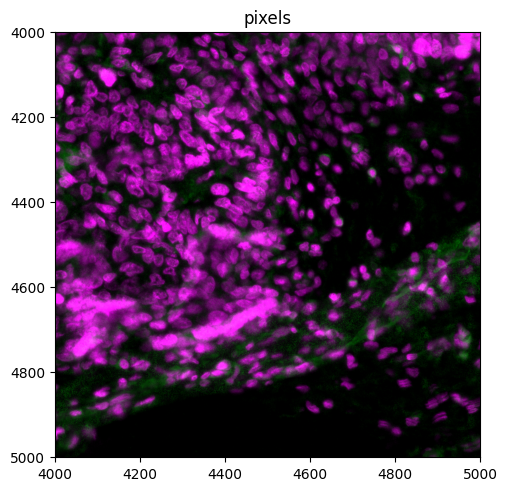

In [21]:
subset_sdata.pl.render_images(element='991_subset_n90_m80_mmm05_proj', alpha=1, channel=['Nuclei', 'Membranes'], palette=['magenta','green']).pl.show()

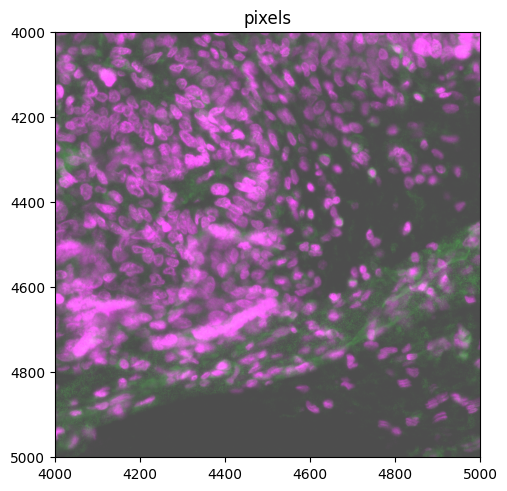

In [23]:
subset_sdata.pl.render_images(element='991_subset_n90_m80_mmm05_proj', alpha=0.7, channel=['Membranes', 'Nuclei'], palette=['green','magenta']).pl.show()

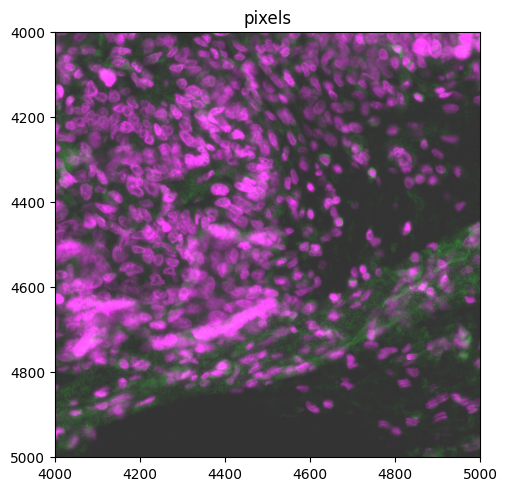

In [29]:
subset_sdata.pl.render_images(element='991_subset_n90_m80_mmm05_proj', alpha=0.8, channel=['Membranes', 'Nuclei'], palette=['green','magenta']).pl.show()

# Segment both ways

In [31]:
subset_sdata

SpatialData object
└── Images
      ├── '991_subset': DataTree[cyx] (15, 1000, 1000), (15, 500, 500), (15, 250, 250), (15, 125, 125), (15, 63, 63)
      └── '991_subset_n90_m80_mmm05_proj': DataArray[cyx] (2, 1000, 1000)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m80_mmm05_proj (Images)

In [32]:
patches = sopa.segmentation.Patches2D(subset_sdata, element_name="991_subset", patch_width=500, patch_overlap=100)
patches.write()

[INFO] (sopa.patches.patches) 9 patches were saved in sdata['sopa_patches']


,geometry,bboxes,ilocs
0,"POLYGON ((500 0, 500 500, 0 500, 0 0, 500 0))","[0, 0, 500, 500]","[0, 0]"
1,"POLYGON ((900 0, 900 500, 400 500, 400 0, 900 0))","[400, 0, 900, 500]","[1, 0]"
2,"POLYGON ((1300 0, 1300 500, 800 500, 800 0, 13...","[800, 0, 1300, 500]","[2, 0]"
3,"POLYGON ((500 400, 500 900, 0 900, 0 400, 500 ...","[0, 400, 500, 900]","[0, 1]"
4,"POLYGON ((900 400, 900 900, 400 900, 400 400, ...","[400, 400, 900, 900]","[1, 1]"
5,"POLYGON ((1300 400, 1300 900, 800 900, 800 400...","[800, 400, 1300, 900]","[2, 1]"
6,"POLYGON ((500 800, 500 1300, 0 1300, 0 800, 50...","[0, 800, 500, 1300]","[0, 2]"
7,"POLYGON ((900 800, 900 1300, 400 1300, 400 800...","[400, 800, 900, 1300]","[1, 2]"
8,"POLYGON ((1300 800, 1300 1300, 800 1300, 800 8...","[800, 800, 1300, 1300]","[2, 2]"


In [34]:
channels = ["Membranes", "Nuclei"]
method = sopa.segmentation.methods.cellpose_patch(diameter=25, channels=channels, flow_threshold=0.6, cellprob_threshold=-6, model_type="cyto3")
segmentation = sopa.segmentation.StainingSegmentation(subset_sdata, method, image_key='991_subset_n90_m80_mmm05_proj', channels=channels, min_area=250)
cellpose_temp_dir = "../zarrs/20240719_991_subset.zarr/.sopa_cache/cellpose"
segmentation.write_patches_cells(cellpose_temp_dir)

[WARNING] (sopa.segmentation.stainings) Running segmentation in a sequential manner. This is not recommended on large images because it can be extremely slow (see https://github.com/gustaveroussy/sopa/discussions/36 for more details)
Run all patches: 100%|██████████| 9/9 [01:19<00:00,  8.88s/it]


In [35]:
cells = sopa.segmentation.StainingSegmentation.read_patches_cells(cellpose_temp_dir)
cells = sopa.segmentation.shapes.solve_conflicts(cells)
sopa.segmentation.StainingSegmentation.add_shapes(subset_sdata, cells, image_key="991_subset", shapes_key="cyto3_Mem_Nuc")

Reading patches: 100%|██████████| 9/9 [00:00<00:00, 181.33it/s]
[INFO] (sopa.segmentation.stainings) Found 652 total cells
Resolving conflicts: 100%|██████████| 804/804 [00:00<00:00, 9510.06it/s]
[INFO] (sopa.segmentation.stainings) Added 478 cell boundaries in sdata['cyto3_Mem_Nuc']


In [36]:
subset_sdata

SpatialData object
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 1000, 1000), (15, 500, 500), (15, 250, 250), (15, 125, 125), (15, 63, 63)
│     └── '991_subset_n90_m80_mmm05_proj': DataArray[cyx] (2, 1000, 1000)
└── Shapes
      ├── 'cyto3_Mem_Nuc': GeoDataFrame shape: (478, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (9, 3) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m80_mmm05_proj (Images), cyto3_Mem_Nuc (Shapes), sopa_patches (Shapes)

In [37]:
channels = ["Nuclei", "Membranes"]
method = sopa.segmentation.methods.cellpose_patch(diameter=25, channels=channels, flow_threshold=0.6, cellprob_threshold=-6, model_type="cyto3")
segmentation = sopa.segmentation.StainingSegmentation(subset_sdata, method, image_key='991_subset_n90_m80_mmm05_proj', channels=channels, min_area=250)
cellpose_temp_dir = "../zarrs/20240719_991_subset.zarr/.sopa_cache/cellpose"
segmentation.write_patches_cells(cellpose_temp_dir)
cells = sopa.segmentation.StainingSegmentation.read_patches_cells(cellpose_temp_dir)
cells = sopa.segmentation.shapes.solve_conflicts(cells)
sopa.segmentation.StainingSegmentation.add_shapes(subset_sdata, cells, image_key="991_subset", shapes_key="cyto3_Nuc_Mem")

[WARNING] (sopa.segmentation.stainings) Running segmentation in a sequential manner. This is not recommended on large images because it can be extremely slow (see https://github.com/gustaveroussy/sopa/discussions/36 for more details)
Reading patches: 100%|██████████| 9/9 [00:00<00:00, 681.88it/s]
[INFO] (sopa.segmentation.stainings) Found 412 total cells
Resolving conflicts: 100%|██████████| 410/410 [00:00<00:00, 9208.28it/s]
[INFO] (sopa.segmentation.stainings) Added 309 cell boundaries in sdata['cyto3_Nuc_Mem']


In [38]:
subset_sdata

SpatialData object
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 1000, 1000), (15, 500, 500), (15, 250, 250), (15, 125, 125), (15, 63, 63)
│     └── '991_subset_n90_m80_mmm05_proj': DataArray[cyx] (2, 1000, 1000)
└── Shapes
      ├── 'cyto3_Mem_Nuc': GeoDataFrame shape: (478, 1) (2D shapes)
      ├── 'cyto3_Nuc_Mem': GeoDataFrame shape: (309, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (9, 3) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m80_mmm05_proj (Images), cyto3_Mem_Nuc (Shapes), cyto3_Nuc_Mem (Shapes), sopa_patches (Shapes)

In [50]:
import rasterize_shapes_into_image
importlib.reload(rasterize_shapes_into_image)

<module 'rasterize_shapes_into_image' from '/Users/jnimoca/Jose_BI/P26_SOPA_seg/jupyternotebooks/../scripts/rasterize_shapes_into_image.py'>

In [51]:
#visualize masks
# step 1 raster
subset_sdata = rasterize_shapes_into_image.rasterize_shapes_into_image(
    sdata=subset_sdata, 
    shape_key='cyto3_Mem_Nuc', 
    ref_image_key='991_subset', 
    name='cyto3_Mem_Nuc_raster')


Rasterization complete. The raster is saved as 'rasterized_perimeters.tif'.


In [52]:
subset_sdata

SpatialData object
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 1000, 1000), (15, 500, 500), (15, 250, 250), (15, 125, 125), (15, 63, 63)
│     ├── '991_subset_n90_m80_mmm05_proj': DataArray[cyx] (2, 1000, 1000)
│     └── 'cyto3_Mem_Nuc_raster': DataArray[cyx] (1, 1000, 1000)
└── Shapes
      ├── 'cyto3_Mem_Nuc': GeoDataFrame shape: (478, 1) (2D shapes)
      ├── 'cyto3_Nuc_Mem': GeoDataFrame shape: (309, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (9, 3) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m80_mmm05_proj (Images), cyto3_Mem_Nuc_raster (Images), cyto3_Mem_Nuc (Shapes), cyto3_Nuc_Mem (Shapes), sopa_patches (Shapes)

In [53]:
subset_sdata = rasterize_shapes_into_image.rasterize_shapes_into_image(
    sdata=subset_sdata, 
    shape_key='cyto3_Nuc_Mem', 
    ref_image_key='991_subset', 
    name='cyto3_Nuc_Mem_raster')

Rasterization complete. The raster is saved as 'rasterized_perimeters.tif'.


In [54]:
subset_sdata

SpatialData object
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 1000, 1000), (15, 500, 500), (15, 250, 250), (15, 125, 125), (15, 63, 63)
│     ├── '991_subset_n90_m80_mmm05_proj': DataArray[cyx] (2, 1000, 1000)
│     ├── 'cyto3_Mem_Nuc_raster': DataArray[cyx] (1, 1000, 1000)
│     └── 'cyto3_Nuc_Mem_raster': DataArray[cyx] (1, 1000, 1000)
└── Shapes
      ├── 'cyto3_Mem_Nuc': GeoDataFrame shape: (478, 1) (2D shapes)
      ├── 'cyto3_Nuc_Mem': GeoDataFrame shape: (309, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (9, 3) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m80_mmm05_proj (Images), cyto3_Mem_Nuc_raster (Images), cyto3_Nuc_Mem_raster (Images), cyto3_Mem_Nuc (Shapes), cyto3_Nuc_Mem (Shapes), sopa_patches (Shapes)

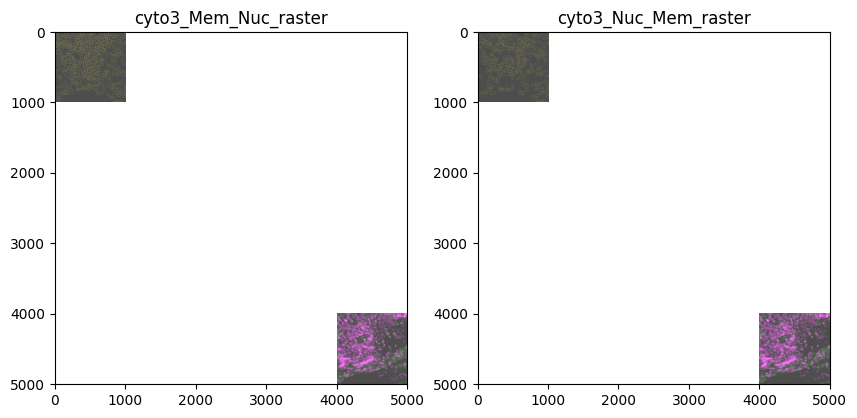

In [56]:
#visualize masks
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

subset_sdata.pl.render_images(element='991_subset_n90_m80_mmm05_proj',  alpha=0.7, channel=['Membranes', 'Nuclei'], palette=['green','magenta']).pl.show(ax=ax[0])
subset_sdata.pl.render_images(element='cyto3_Mem_Nuc_raster',           alpha=0.7, channel=['cyto3_Mem_Nuc'], palette=['yellow']).pl.show(ax=ax[0], title='cyto3_Mem_Nuc')

subset_sdata.pl.render_images(element='991_subset_n90_m80_mmm05_proj',  alpha=0.7, channel=['Nuclei', 'Membranes'], palette=['magenta','green']).pl.show(ax=ax[1])
subset_sdata.pl.render_images(element='cyto3_Nuc_Mem_raster',           alpha=0.7, channel=['cyto3_Nuc_Mem'], palette=['yellow']).pl.show(ax=ax[1], title='cyto3_Nuc_Mem')

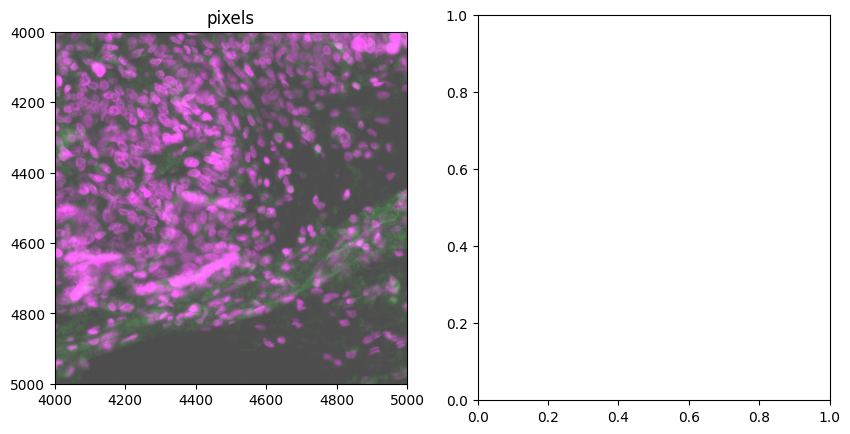

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

subset_sdata.pl.render_images(element='991_subset_n90_m80_mmm05_proj',  alpha=0.7, channel=['Membranes', 'Nuclei'], palette=['green','magenta']).pl.show(ax=ax[0])

In [60]:
subset_sdata.images['cyto3_Mem_Nuc_raster']

<xarray.DataArray 'image' (c: 1, y: 1000, x: 1000)> Size: 2MB
dask.array<array, shape=(1, 1000, 1000), dtype=uint16, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 8B 0
  * y        (y) float64 8kB 0.5 1.5 2.5 3.5 4.5 ... 996.5 997.5 998.5 999.5
  * x        (x) float64 8kB 0.5 1.5 2.5 3.5 4.5 ... 996.5 997.5 998.5 999.5
Attributes:
    transform:  {'pixels': Identity }

In [61]:
subset_sdata.images['991_subset_n90_m80_mmm05_proj']

<xarray.DataArray 'image' (c: 2, y: 1000, x: 1000)> Size: 2MB
dask.array<getitem, shape=(2, 1000, 1000), dtype=uint8, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
    quantile  (c) float64 16B 0.9 0.8
  * c         (c) <U9 72B 'Nuclei' 'Membranes'
  * y         (y) float64 8kB 0.5 1.5 2.5 3.5 4.5 ... 996.5 997.5 998.5 999.5
  * x         (x) float64 8kB 0.5 1.5 2.5 3.5 4.5 ... 996.5 997.5 998.5 999.5
Attributes:
    transform:  {'pixels': Sequence \n    Translation (x, y)\n        [4000. ...

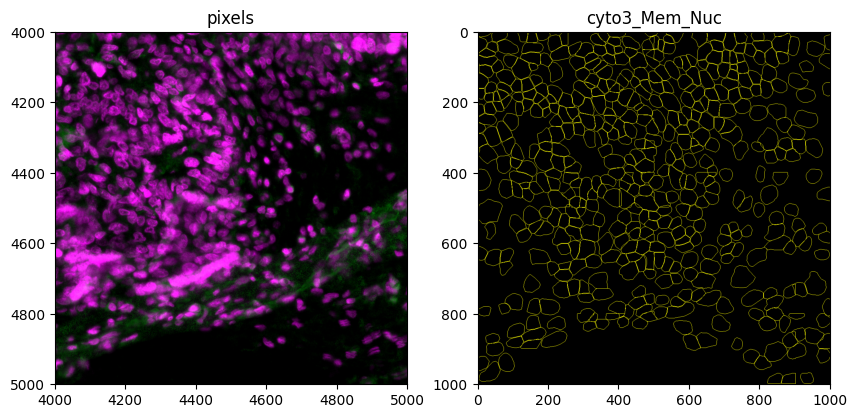

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
subset_sdata.pl.render_images(element='991_subset_n90_m80_mmm05_proj',  alpha=1, channel=['Membranes', 'Nuclei'], palette=['green','magenta']).pl.show(ax=ax[0])
subset_sdata.pl.render_images(element='cyto3_Mem_Nuc_raster',           alpha=1, channel=['cyto3_Mem_Nuc'], palette=['yellow']).pl.show(ax=ax[1], title='cyto3_Mem_Nuc')

# Challenge: Export image as tif, shapes as tif (labels)

In [74]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/P26_SOPA_seg/zarrs/20240719_991_subset.zarr
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
│     └── '991_subset_n90_m80_mmm05_proj': DataArray[cyx] (2, 8000, 8000)
└── Shapes
      └── 'sopa_patches': GeoDataFrame shape: (36, 3) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m80_mmm05_proj (Images), sopa_patches (Shapes)

In [75]:
sdata.write('../zarrs/20240719_991_subset_2.zarr')

INFO     The Zarr backing store has been changed from ../zarrs/20240719_991_subset.zarr the new file path:         
         ../zarrs/20240719_991_subset_2.zarr                                                                       


In [77]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/P26_SOPA_seg/zarrs/20240719_991_subset_2.zarr
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
│     └── '991_subset_n90_m80_mmm05_proj': DataArray[cyx] (2, 8000, 8000)
└── Shapes
      └── 'sopa_patches': GeoDataFrame shape: (36, 3) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m80_mmm05_proj (Images), sopa_patches (Shapes)

In [79]:
sdata.delete_element_from_disk('sopa_patches')

In [81]:
sdata = spatialdata.SpatialData.read('../zarrs/20240719_991_subset_2.zarr')

In [82]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/P26_SOPA_seg/zarrs/20240719_991_subset_2.zarr
└── Images
      ├── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
      └── '991_subset_n90_m80_mmm05_proj': DataArray[cyx] (2, 8000, 8000)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m80_mmm05_proj (Images)

In [83]:
patches = sopa.segmentation.Patches2D(sdata, element_name="991_subset", patch_width=1500, patch_overlap=100)
patches.write()

[INFO] (sopa.patches.patches) 36 patches were saved in sdata['sopa_patches']


,geometry,bboxes,ilocs
0,"POLYGON ((1500 0, 1500 1500, 0 1500, 0 0, 1500...","[0, 0, 1500, 1500]","[0, 0]"
1,"POLYGON ((2900 0, 2900 1500, 1400 1500, 1400 0...","[1400, 0, 2900, 1500]","[1, 0]"
2,"POLYGON ((4300 0, 4300 1500, 2800 1500, 2800 0...","[2800, 0, 4300, 1500]","[2, 0]"
3,"POLYGON ((5700 0, 5700 1500, 4200 1500, 4200 0...","[4200, 0, 5700, 1500]","[3, 0]"
4,"POLYGON ((7100 0, 7100 1500, 5600 1500, 5600 0...","[5600, 0, 7100, 1500]","[4, 0]"
5,"POLYGON ((8500 0, 8500 1500, 7000 1500, 7000 0...","[7000, 0, 8500, 1500]","[5, 0]"
6,"POLYGON ((1500 1400, 1500 2900, 0 2900, 0 1400...","[0, 1400, 1500, 2900]","[0, 1]"
7,"POLYGON ((2900 1400, 2900 2900, 1400 2900, 140...","[1400, 1400, 2900, 2900]","[1, 1]"
8,"POLYGON ((4300 1400, 4300 2900, 2800 2900, 280...","[2800, 1400, 4300, 2900]","[2, 1]"
9,"POLYGON ((5700 1400, 5700 2900, 4200 2900, 420...","[4200, 1400, 5700, 2900]","[3, 1]"


In [84]:
channels = ["Membranes", "Nuclei"]
method = sopa.segmentation.methods.cellpose_patch(diameter=25, channels=channels, flow_threshold=0.6, cellprob_threshold=-6, model_type="cyto3")
segmentation = sopa.segmentation.StainingSegmentation(sdata, method, image_key='991_subset_n90_m80_mmm05_proj', channels=channels, min_area=250)
cellpose_temp_dir = "../zarrs/20240719_991_subset_2.zarr/.sopa_cache/cellpose"
segmentation.write_patches_cells(cellpose_temp_dir)

[WARNING] (sopa.segmentation.stainings) Running segmentation in a sequential manner. This is not recommended on large images because it can be extremely slow (see https://github.com/gustaveroussy/sopa/discussions/36 for more details)
Run all patches: 100%|██████████| 36/36 [11:08<00:00, 18.58s/it]


In [112]:
cells = sopa.segmentation.StainingSegmentation.read_patches_cells(cellpose_temp_dir)
cells = sopa.segmentation.shapes.solve_conflicts(cells)
sopa.segmentation.StainingSegmentation.add_shapes(sdata, cells, image_key="991_subset", shapes_key="cyto3")

Reading patches: 100%|██████████| 36/36 [00:00<00:00, 215.10it/s]
[INFO] (sopa.segmentation.stainings) Found 20714 total cells
Resolving conflicts: 100%|██████████| 10386/10386 [00:01<00:00, 10180.88it/s]
[INFO] (sopa.segmentation.stainings) Added 18574 cell boundaries in sdata['cyto3']


## Export image as ome.tif

In [99]:
image = sdata.images['991_subset']['scale0'].image.values

print(type(image), image.shape)

<class 'numpy.ndarray'> (15, 8000, 8000)


In [100]:
import tifffile

In [102]:
tifffile.imwrite("../data/image.ome.tif", image, photometric='rgb')

## Export shapes as mask tif

In [114]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/P26_SOPA_seg/zarrs/20240719_991_subset_2.zarr
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
│     └── '991_subset_n90_m80_mmm05_proj': DataArray[cyx] (2, 8000, 8000)
└── Shapes
      ├── 'cyto3': GeoDataFrame shape: (18574, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (36, 3) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m80_mmm05_proj (Images), cyto3 (Shapes), sopa_patches (Shapes)

In [123]:
mask = spatialdata.rasterize(data=sdata.shapes['cyto3'],
                                    axes=['x', 'y'],
                                    min_coordinate=[0,0], 
                                    max_coordinate=[8000,8000], 
                                    target_coordinate_system='pixels',
                                    target_width=8000, )

In [133]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/P26_SOPA_seg/zarrs/20240719_991_subset_2.zarr
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
│     └── '991_subset_n90_m80_mmm05_proj': DataArray[cyx] (2, 8000, 8000)
└── Shapes
      ├── 'cyto3': GeoDataFrame shape: (18574, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (36, 3) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m80_mmm05_proj (Images), cyto3 (Shapes), sopa_patches (Shapes)

In [134]:
mask.shape

(1, 8000, 8000)

In [129]:
mask_drop = mask.drop_dims('c')

AttributeError: 'DataArray' object has no attribute 'drop_dims'

In [139]:
mask.drop_dims('c')

AttributeError: 'DataArray' object has no attribute 'drop_dims'

In [142]:
selected_data_array = mask.isel(c=0)

In [143]:
selected_data_array

<xarray.DataArray 'image' (y: 8000, x: 8000)> Size: 512MB
dask.array<getitem, shape=(8000, 8000), dtype=float64, chunksize=(4096, 4096), chunktype=numpy.ndarray>
Coordinates:
    c        int64 8B 0
  * y        (y) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
  * x        (x) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
Attributes:
    x_range:                  (0.0, 8000.0)
    y_range:                  (0.0, 8000.0)
    label_index_to_category:  {1: '991_subset0', 2: '991_subset1', 3: '991_su...
    transform:                {'pixels': Sequence \n    Scale (y, x)\n       ...

In [146]:
sdata.labels['cyto3_label'] = spatialdata.models.Labels2DModel.parse(selected_data_array)

In [147]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/P26_SOPA_seg/zarrs/20240719_991_subset_2.zarr
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
│     └── '991_subset_n90_m80_mmm05_proj': DataArray[cyx] (2, 8000, 8000)
├── Labels
│     └── 'cyto3_label': DataArray[yx] (8000, 8000)
└── Shapes
      ├── 'cyto3': GeoDataFrame shape: (18574, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (36, 3) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m80_mmm05_proj (Images), cyto3_label (Labels), cyto3 (Shapes), sopa_patches (Shapes)
with the following elements not in the Zarr store:
    ▸ cyto3_label (Labels)

In [ ]:
export label as tif

In [151]:
labels_numpy_array = sdata.labels['cyto3_label'].values

In [152]:
print(labels_numpy_array.shape)
print(labels_numpy_array.dtype)
print(type(labels_numpy_array))

(8000, 8000)
float64
<class 'numpy.ndarray'>


In [153]:
import skimage.io

In [154]:
skimage.io.imsave("../data/labels.tif", labels_numpy_array)

In [155]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/P26_SOPA_seg/zarrs/20240719_991_subset_2.zarr
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
│     └── '991_subset_n90_m80_mmm05_proj': DataArray[cyx] (2, 8000, 8000)
├── Labels
│     └── 'cyto3_label': DataArray[yx] (8000, 8000)
└── Shapes
      ├── 'cyto3': GeoDataFrame shape: (18574, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (36, 3) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m80_mmm05_proj (Images), cyto3_label (Labels), cyto3 (Shapes), sopa_patches (Shapes)
with the following elements not in the Zarr store:
    ▸ cyto3_label (Labels)

In [156]:
subset_sdata = sdata.query.bounding_box(
            axes=["x", "y"],
            min_coordinate=[4000, 4000],
            max_coordinate=[5000, 5000],
            target_coordinate_system='pixels')

In [157]:
subset_sdata

SpatialData object
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 1000, 1000), (15, 500, 500), (15, 250, 250), (15, 125, 125), (15, 63, 63)
│     └── '991_subset_n90_m80_mmm05_proj': DataArray[cyx] (2, 1000, 1000)
├── Labels
│     └── 'cyto3_label': DataArray[yx] (1000, 1000)
└── Shapes
      ├── 'cyto3': GeoDataFrame shape: (444, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (4, 3) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m80_mmm05_proj (Images), cyto3_label (Labels), cyto3 (Shapes), sopa_patches (Shapes)

## now from tif to geojson

### easy way

In [159]:
gdf = subset_sdata.shapes['cyto3'] 

In [163]:
gdf.to_file(filename="../data/cyto3.geojson")

/opt/homebrew/Caskroom/mambaforge/base/envs/SOPA3/lib/python3.10/site-packages/pyogrio/raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(


In [164]:
sdata.shapes['cyto3'].to_file(filename="../data/cyto3_full.geojson")

/opt/homebrew/Caskroom/mambaforge/base/envs/SOPA3/lib/python3.10/site-packages/pyogrio/raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(


### from tif to geodataframe

In [ ]:
import rasterio
import geopandas as gpd
from shapely.geometry import shape
from rasterio.features import shapes
import numpy as np
import pandas as pd

In [200]:
labels_numpy_array.dtype

dtype('float64')

In [ ]:
rasterio.features.shapes(source=labels_numpy_array.astype(np.int32), mask=None, connectivity=4, transform=rasterio.transform.from_origin(0, 0, 1, 1))

In [185]:
tif_path = "../data/labels.tif"

with rasterio.open(tif_path) as src:
        # Read the image data
        image = src.read(1)  # Read the first band
        
        # Define the affine transformation
        transform = src.transform
        
        # Extract the shapes and values from the raster
        results = list(shapes(image.astype(np.float32), transform=transform))

/opt/homebrew/Caskroom/mambaforge/base/envs/SOPA3/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [194]:
results[0]

({'type': 'Polygon',
  'coordinates': [[(1599.0, 0.0),
    (1599.0, 1.0),
    (1600.0, 1.0),
    (1600.0, 2.0),
    (1601.0, 2.0),
    (1601.0, 3.0),
    (1602.0, 3.0),
    (1602.0, 1.0),
    (1603.0, 1.0),
    (1603.0, 0.0),
    (1599.0, 0.0)]]},
 0.0)

In [195]:
results[0][0]

{'type': 'Polygon',
 'coordinates': [[(1599.0, 0.0),
   (1599.0, 1.0),
   (1600.0, 1.0),
   (1600.0, 2.0),
   (1601.0, 2.0),
   (1601.0, 3.0),
   (1602.0, 3.0),
   (1602.0, 1.0),
   (1603.0, 1.0),
   (1603.0, 0.0),
   (1599.0, 0.0)]]}

In [196]:
results[0][1]

0.0

In [197]:
results[1][0]

{'type': 'Polygon',
 'coordinates': [[(7408.0, 0.0),
   (7408.0, 2.0),
   (7409.0, 2.0),
   (7409.0, 3.0),
   (7410.0, 3.0),
   (7410.0, 4.0),
   (7411.0, 4.0),
   (7411.0, 2.0),
   (7412.0, 2.0),
   (7412.0, 0.0),
   (7408.0, 0.0)]]}

In [198]:
results[1][1]

0.0

In [ ]:
geometries = [shape(geom) for geom, value in results]

In [219]:
import rasterio
import geopandas as gpd
from shapely.geometry import shape
from rasterio.features import shapes
import numpy as np
import pandas as pd

def raster_to_geodataframe(tif_path, output_path, crs='EPSG:4326'):
    """
    Convert a TIFF file with segmentation labels to a GeoDataFrame.
    
    Parameters:
    - tif_path: str, path to the input TIFF file.
    - crs: str, the Coordinate Reference System of the output GeoDataFrame.
    
    Returns:
    - GeoDataFrame containing the polygons and their associated labels.
    """

    assert tif_path.endswith('.tif'), "Input file must be a TIFF file"
    assert output_path.endswith('.geojson'), "Output file must end in .geojson"

    with rasterio.open(tif_path) as src:
        # Read the image data
        image = src.read(1)  # Read the first band
        
        # Define the affine transformation
        transform = src.transform
        
        # Extract the shapes and values from the raster
        results = list(shapes(image.astype(np.int32), transform=transform))
        
        # Create a DataFrame from the shapes and values
        geometries = [shape(geom) for geom, value in results]
        values = [value for geom, value in results]

        # Filter out polygons with a value of 0.0
        filtered_geometries = [geom for geom, value in zip(geometries, values) if value != 0.0]
        filtered_values = [value for value in values if value != 0.0]
        
        # Create a DataFrame with required columns
        df = pd.DataFrame({
            'geometry': filtered_geometries,
            'objectType': ['annotation'] * len(filtered_geometries),
            'name': filtered_values
        })
        
        # Create a GeoDataFrame
        gdf = gpd.GeoDataFrame(df, geometry='geometry')
        
        # Set the coordinate reference system (CRS)
        gdf.crs = crs

    print(f"GeoDataFrame created, now saving to {output_path}")
    gdf.to_file(output_path)
    
    return gdf

In [203]:

# Path to your TIFF file
tif_path = '/Users/jnimoca/Jose_BI/P26_SOPA_seg/data/labels.tif'





print("GeoDataFrame created and saved as 'output_labels.shp'")

/opt/homebrew/Caskroom/mambaforge/base/envs/SOPA3/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


GeoDataFrame created and saved as 'output_labels.shp'


In [220]:

# Path to your TIFF file
tif_path = "/Users/jnimoca/Jose_BI/data/mask_expansion_mesmer/segmentation_expansion/1.tif" 

# Convert the TIFF file to a GeoDataFrame
gdf = raster_to_geodataframe(tif_path)

# Save to a shapefile or other formats if needed
gdf.to_file('../output_labels_names.geojson')

/opt/homebrew/Caskroom/mambaforge/base/envs/SOPA3/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
